In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy as sp
import scipy.linalg
import scipy.optimize
# import scipy.special

from mpl_toolkits.mplot3d import Axes3D

%matplotlib widget

In [2]:
class Jackknife:
    def do_it( self ):
        for i in range( 0, self.nbins ):
            self.est += self.jack_avg[i]
        self.est /= self.nbins

        for i in range( 0, self.nbins ):
            self.var_est += ( self.jack_avg[i] - self.est )**2
        self.var_est /= self.nbins
        self.var_est *= self.nbins -1

    def __init__( self, nbins, binsize, binned ):
        self.binsize = binsize
        self.nbins = nbins
        self.N = self.binsize * self.nbins
        self.binned = binned
        self.jack_avg = []
        self.est = 0
        self.var_est = 0
        
        for i in range( 0, self.nbins ):
            resmpld = np.delete(binned, i, 0)
            self.jack_avg.append( np.mean(resmpld, 0) )
            
        self.do_it()

    def mean( self ):
        return self.est

    def var( self ):
        return self.var_est

    def err( self ):
        return np.sqrt(self.var_est)
    
def format_print(cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'

def format_print_w_exact(exact, cen, err):
    for i in range(-50, 50):
        if 10**(-i+1)>=err>10**(-i):
            tmp=err*10**(i+1)
            return '{num:.{width}f}'.format(num=cen, width=i+1)+'('+str(round(tmp))+')'+': '+'{num:.{width}f}'.format(num=(exact-cen)/err, width=i+1)+' sigma'

In [3]:
def theta(z, Tau, n=0, nmax=1e5, tol=1.0e-15):
    
    if n==0:
        r = np.pi*1.0j/Tau
        s = np.exp( -r*z**2 )

        s_old = s
        for ell in np.arange(1,nmax):
            s += np.exp( -r*(ell+z)**2 )
            s += np.exp( -r*(-ell+z)**2 )

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = 1.0 / np.sqrt(-1.0j*Tau)
        return coeff * s

    else:

        r = np.pi*1.0j/Tau
        arr = np.full(n+1, 0)
        arr[n]=1
        Hn = np.polynomial.hermite.Hermite( arr )

        coeff = Hn( np.sqrt(r)*z )
        exp = np.exp( -r*z**2 )
        s = coeff * exp

        s_old = s
        for ell in np.arange(1,nmax):
            coeff = Hn( np.sqrt(r)*(ell+z) )
            exp = np.exp( -r*(ell+z)**2 )
            s += coeff * exp

            coeff = Hn( np.sqrt(r)*(-ell+z) )
            exp = np.exp( -r*(-ell+z)**2 )
            s += coeff * exp

            if np.abs(s-s_old)<tol: break
            s_old = s
            if ell==nmax-1: 
                print("did not converge for z = ", z)
                return np.nan
                assert(False)

        coeff = (-1)**n * r**(n/2) / np.sqrt(-1.0j*Tau)

        return coeff * s

In [4]:
def th1(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau+0.5, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    return -coeff * s


def th2(z, n=0):
    s = 0.0
    for k in np.arange(n+1):
        A = (np.pi*1.0j)**k
        B = theta( z+0.5*tau, tau, n-k )
        binomial = scipy.special.comb(n,k)
        s += binomial * A * B

    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    return coeff * s

def th3(z, n=0):
    return theta(z, tau, n)

def th4(z, n=0):
    return theta(z+0.5, tau, n)

In [5]:
def P(z):
    res = 0.0
    
    tmp = np.pi * th20*th30*th4(z)/th1(z)
    res += tmp**2
    
    tmp = th20**4 + th30**4
    tmp *= np.pi**2/3.0
    res -= tmp
    
    return res

def dP(z):
    coeff = (np.pi * th20*th30)**2
    
    f1 = th4(z) * th4(z,1) / th1(z)**2
    f2 = th4(z)**2 * th1(z,1) / th1(z)**3

    res = 2.0 * coeff * (f1-f2)
    
    return res

def ddP(z):    
    coeff = (np.pi * th20*th30)**2
    
    f1 = ( th4(z,1)**2 + th4(z) * th4(z,2) ) / th1(z)**2
    f2 = th4(z) * th4(z,1) * th1(z,1) / th1(z)**3
    f3 = th4(z)**2 * th1(z,2) / th1(z)**3
    f4 = th4(z)**2 * th1(z,1)**2 / th1(z)**4

    res = 2.0 * coeff * (f1 - 4.0*f2 -f3 + 3.0*f4 )
    
    return res

In [6]:
def P2(z):
    return th1p0/th20 * th2(z)/th1(z)

def P3(z):
    return th1p0/th30 * th3(z)/th1(z)

def P4(z):
    return th1p0/th40 * th4(z)/th1(z)

# def P2Alt(z):
#     return np.sqrt( P(z)-e1 )
# def P3Alt(z):
#     return np.sqrt( P(z)-e2 )
# def P4Alt(z):
#     return np.sqrt( P(z)-e3 )

In [7]:
def dP2(z):
    return th1p0/th20 * ( th2(z,1)/th1(z) - th2(z)*th1(z,1)/th1(z)**2 )

def ddP2(z):
    return th1p0/th20 * ( th2(z,2)/th1(z) - 2.0*th2(z,1)*th1(z,1)/th1(z)**2 - th2(z)*th1(z,2)/th1(z)**2 + 2.0*th2(z)*th1(z,1)**2/th1(z)**3 )

In [8]:
def dP3(z):
    return th1p0/th30 * ( th3(z,1)/th1(z) - th3(z)*th1(z,1)/th1(z)**2 )

def ddP3(z):
    return th1p0/th30 * ( th3(z,2)/th1(z) - 2.0*th3(z,1)*th1(z,1)/th1(z)**2 - th3(z)*th1(z,2)/th1(z)**2 + 2.0*th3(z)*th1(z,1)**2/th1(z)**3 )

In [9]:
def dP4(z):
    return th1p0/th40 * ( th4(z,1)/th1(z) - th4(z)*th1(z,1)/th1(z)**2 )

def ddP4(z):
    return th1p0/th40 * ( th4(z,2)/th1(z) - 2.0*th4(z,1)*th1(z,1)/th1(z)**2 - th4(z)*th1(z,2)/th1(z)**2 + 2.0*th4(z)*th1(z,1)**2/th1(z)**3 )

In [10]:
def Dth1(z):
    im = 0.25*np.pi*tau + np.pi*(z+0.5)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th1(z)
    s -= 0.5*coeff * th3(z+0.5*tau+0.5, 1)
    s -= 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau+0.5, 2)
    return s

def Dth2(z):
    im = 0.25*np.pi*tau + np.pi*(z)
    coeff = np.exp( 1.0j*im )

    s = 0.0
    s += 0.25*1.0j*np.pi * th2(z)
    s += 0.5*coeff * th3(z+0.5*tau, 1)
    s += 1.0/(4.0*np.pi*1.0j)*coeff * th3(z+0.5*tau, 2)
    return s

def Dth3(z):
    return 1.0/(4.0*np.pi*1.0j) * th3(z, 2)

def Dth4(z):
    return 1.0/(4.0*np.pi*1.0j) * th4(z, 2)

In [11]:
def dedekind( t ):
    return np.exp( np.pi*1.0j*t/12.0 ) * theta(0.5*(t+1.0), 3.0*t)

In [12]:
def Ddedekind( t ):
    res = 0.0
    res += np.pi*1.0j/12.0 * dedekind(t)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 0.5 * theta(0.5*(t+1.0), 3.0*t, 1)
    res += np.exp( np.pi*1.0j*t/12.0 ) * 3.0 / (4.0*np.pi*1.0j) * theta(0.5*(t+1.0), 3.0*t, 2)
    return res

In [13]:
def ZM( nu ):
    eta = dedekind( tau )
    coeff = 1.0/(2.0* np.abs(eta) )

    if nu == 2: res = coeff * np.abs(th20)
    elif nu == 3: res = coeff * np.abs(th30)
    elif nu == 4: res = coeff * np.abs(th40)
    elif nu == 1: res = 0.0
    
    return res

In [14]:
def ZI( nu ):
    res = 0.0
    
    for nup in range(1, 5):
        if nup == nu: continue
        else: res += ZM(nup)

    res -= ZM(nu)
    res *= 0.5
    
    return res

In [15]:
def ZMss_nu(z, nu):
    factor = 0.5 * (2.0*np.pi)**(1.0/3.0) * np.abs( th1p0**(-1.0/12.0) )
    denom = np.abs( th1(z) )**(1/4)
    
    if nu==1: numer=np.abs( th1(0.5*z) )
    elif nu==2: numer=np.abs( th2(0.5*z) )
    elif nu==3: numer=np.abs( th3(0.5*z) )
    elif nu==4: numer=np.abs( th4(0.5*z) )
    else: assert(false)
    
    return factor * numer/denom

In [16]:
def ZMtot():
    res = 0.0
    for nup in range(1, 5):
        res += ZM(nup)
    return res

In [17]:
def ss_corr_analytic(z):
    res = 0.0
    for nu in range(1,5):
        res += ZMss_nu( z,nu )

    res /= ZMtot()
    
    return res

In [18]:
def epseps_corr_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * np.abs( P2(z) )**2
    res += ZM( 3 ) * np.abs( P3(z) )**2
    res += ZM( 4 ) * np.abs( P4(z) )**2

    res /= ZMtot()
    
    return res

In [19]:
def T_1pt_analytic():
    res = 0.0
    
    res += ZM( 2 ) * e1
    res += ZM( 3 ) * e2
    res += ZM( 4 ) * e3

    res /= ZMtot()
    res *= -0.25
    
    return res

In [20]:
def eps_1pt_analytic():
    eta = dedekind( tau )
    sumTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
    return 2.0 * np.pi * np.abs(eta)**3 / sumTh

In [21]:
def TTconn2(z):
    return -0.25 * ( dP2(z)**2 - ddP2(z)*P2(z) )

def TTconn3(z):
    return -0.25 * ( dP3(z)**2 - ddP3(z)*P3(z) )

def TTconn4(z):
    return -0.25 * ( dP4(z)**2 - ddP4(z)*P4(z) )

def TT_analytic(z):
    res = 0.0
    
    res += ZM( 2 ) * (TTconn2(z) + (-0.25*e1)**2 )
    res += ZM( 3 ) * (TTconn3(z) + (-0.25*e2)**2 )
    res += ZM( 4 ) * (TTconn4(z) + (-0.25*e3)**2 )

    res /= ZMtot()
    
    return res

In [22]:
def De2():
    fac = np.pi*1.0j
    tmp = e2**2 - 1.0/6.0 * g2 - 2.0*eta1*e2
    return tmp/fac

In [23]:
def De3():
    fac = np.pi*1.0j
    tmp = e3**2 - 1.0/6.0 * g2 - 2.0*eta1*e3
    return tmp/fac

In [24]:
def De1():
    fac = np.pi*1.0j
    tmp = e1**2 - 1.0/6.0 * g2 - 2.0*eta1*e1
    return tmp/fac

In [25]:
def TTconn2Alt(z):
    z = zz
    c1 = 2.0*np.pi*1.0j* ( -0.25*De1() ) 
    c2 = 1.0/24.0 * ddP(z)
    c3 = 2.0*(-0.25*e1) * ( P(z) + 2.0*eta1 )
    return c1+c2+c3

def TTconn3Alt(z):
    z = zz
    c1 = 2.0*np.pi*1.0j* ( -0.25*De2() ) 
    c2 = 1.0/24.0 * ddP(z)
    c3 = 2.0*(-0.25*e2) * ( P(z) + 2.0*eta1 )
    return c1+c2+c3

def TTconn4Alt(z):
    z = zz
    c1 = 2.0*np.pi*1.0j* ( -0.25*De3() ) 
    c2 = 1.0/24.0 * ddP(z)
    c3 = 2.0*(-0.25*e3) * ( P(z) + 2.0*eta1 )
    return c1+c2+c3

In [26]:
def Teps_sing(z):
    res = 0.0
    res += 0.5 * ( P(z) + 2.0*eta1 ) * eps_1pt_analytic()
    return res

In [27]:
def Deps_1pt_analytic():
    eta = dedekind(tau)
    Deta = Ddedekind(tau)

    DAbsEta = 0.5 * Deta * np.conj(eta) / np.abs(eta)

    DAbsTh2 = 0.5 * Dth2(0) * np.conj(th20) / np.abs(th20)
    DAbsTh3 = 0.5 * Dth3(0) * np.conj(th30) / np.abs(th30)
    DAbsTh4 = 0.5 * Dth4(0) * np.conj(th40) / np.abs(th40)

    sumAbsTh = np.abs(th20) + np.abs(th30) + np.abs(th40)
    sumDAbsTh = DAbsTh2 + DAbsTh3 + DAbsTh4

    f1 = 2.0*np.pi * eta**3 * sumDAbsTh / sumAbsTh**2
    f2 = 6.0*np.pi * eta**2 * DAbsEta / sumAbsTh

    return 2.0*np.pi*1.0j* (-f1 + f2)

In [41]:
# Lx = 9
# Ly = 12
mult=4
Lx = 6*mult
Ly = 3*mult

tau = Ly/Lx*np.exp( 1.0j*np.pi/3 )

Nbintot = 5
binsize = 1e3
# Nbintot = 4
# binsize = 1e2

nskip = 1
Nbin = Nbintot-nskip

In [42]:
th1p0 = th1(0, 1)
th20 = th2(0)
th30 = th3(0)
th40 = th4(0)

e1 = 1.0/3.0 * (np.pi)**2 * (th30**4 + th40**4)
e2 = 1.0/3.0 * (np.pi)**2 * (th20**4 - th40**4)
e3 = -1.0/3.0 * (np.pi)**2 * (th20**4 + th30**4)

eta1 = -1.0/6.0 * th1(0, n=3)/th1(0, n=1)

g2 = -4.0 * ( e2*e3 + e3*e1 + e1*e2 )
g3 = 4.0 * e1*e2*e3

In [43]:
eps = 1.0e-5

In [44]:
zz = 0.2+0.3j
( P2( zz+eps )-P2( zz-eps ) ) / (2.0*eps)

(-33.949406697475474-25.18107889537546j)

In [45]:
TTconn2(zz) - TTconn2Alt(zz)

(2.1316282072803006e-14+6.821210263296962e-13j)

In [46]:
TTconn3(zz) - TTconn3Alt(zz)

(-8.526512829121202e-14+1.3642420526593924e-12j)

In [47]:
TTconn4(zz) - TTconn4Alt(zz)

(-1.1368683772161603e-13-5.684341886080801e-13j)

In [48]:
# directory1="./runs/mult"+str(mult)+"/data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1/"
directory1="./data_Lx"+str(Lx)+"Ly"+str(Ly)+"nu1/"

In [49]:
kappa = 2.0/3.0
cos = np.cos( np.pi/6.0 )
B = cos / ( 1.0 - kappa**2 * cos**2 )
alat = 1.0/Lx

tanhbeta = kappa*cos

alat = 1.0/Lx
r = np.sqrt(3.0/2.0 * np.sqrt(3.0) * alat) # 

## $\sigma\sigma$

In [50]:
Nbintot

5

In [51]:
ss_corr1 = np.array([np.loadtxt(directory1+"ss_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])
jk1 = Jackknife( Nbin, binsize, ss_corr1[nskip:] )

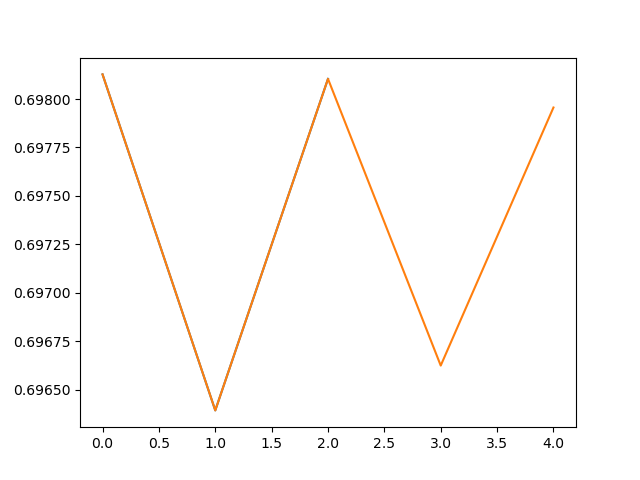

In [52]:
# plt.close()
plt.plot(ss_corr1[:,1,1])
plt.show()

In [53]:
shape = jk1.mean().shape
jkm = jk1.mean()
jke = jk1.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

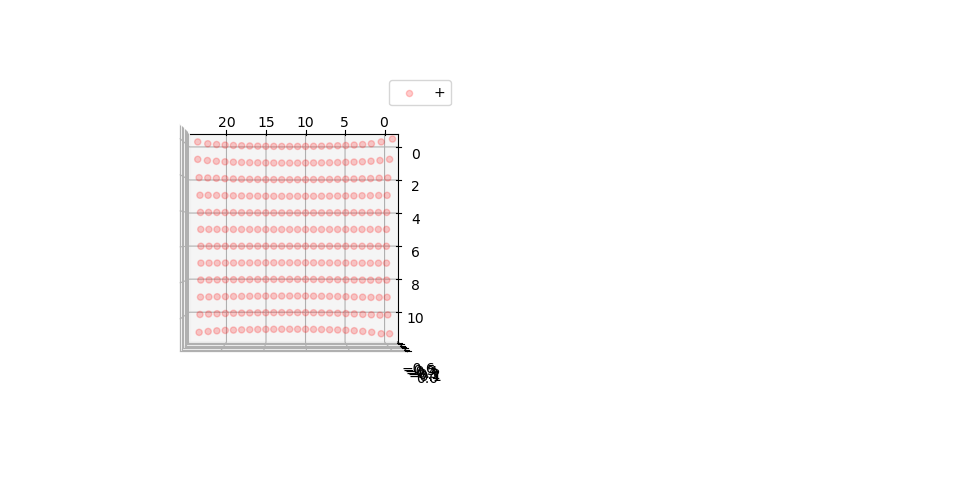

In [54]:
# plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

plt.show()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')

In [55]:
u = np.sqrt( 3.0/alat**0.25 * 0.5*kappa*B )

In [56]:
t = 0

yt = ss1[t*Lx:(t+1)*Lx]

fac = u**2
# fac = 3.4
# fac = 4.05
# fac = 0.29

In [57]:
np.log( fac * yt.T[2])

array([1.05613753, 0.81599087, 0.65421769, 0.58519429, 0.53667751,
       0.49956424, 0.47315835, 0.45244059, 0.43596971, 0.42442543,
       0.41675621, 0.41205429, 0.41068269, 0.41205429, 0.41675621,
       0.42442543, 0.43596971, 0.45244059, 0.47315835, 0.49956424,
       0.53667751, 0.58519429, 0.65421769, 0.81599087])

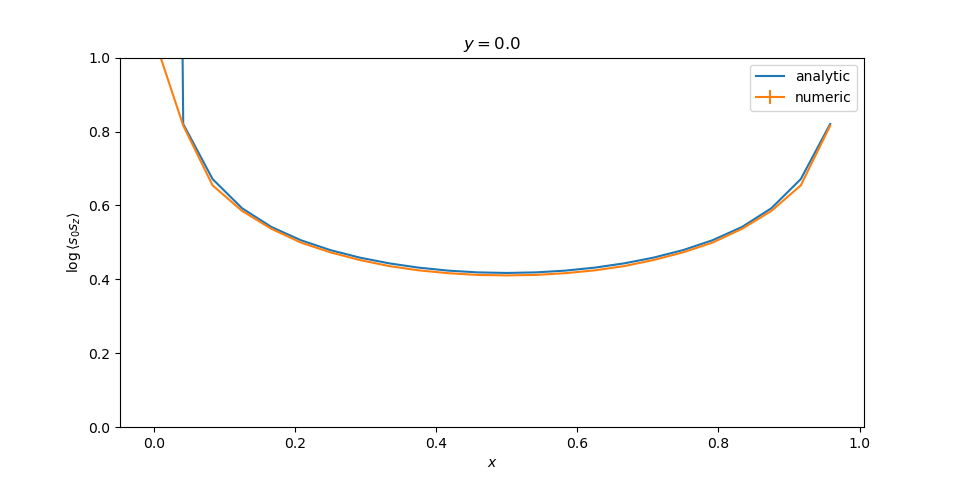

In [58]:
# plt.close()
plt.clf()
x = np.arange(0, Lx)/Lx
y = np.array( [ss_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( yt.T[0]/Lx, np.log( fac * yt.T[2]), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 1.0 )

# plt.xscale("log")

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.savefig('./ss_yslice.pdf',bbox_inches='tight')
plt.show()

In [59]:
t = 0
xt = ss1[t::Lx]
t

0

In [60]:
np.log(fac * xt.T[2])

array([1.05613753, 0.81791471, 0.66058872, 0.5994334 , 0.5627578 ,
       0.54115571, 0.53456688, 0.54115571, 0.5627578 , 0.5994334 ,
       0.66058872, 0.81791471])

In [61]:
np.abs(xt.T[3]/xt.T[2])

array([0.        , 0.00074466, 0.00081613, 0.00101063, 0.00089168,
       0.00085928, 0.00088309, 0.00085928, 0.00089168, 0.00101063,
       0.00081613, 0.00074466])

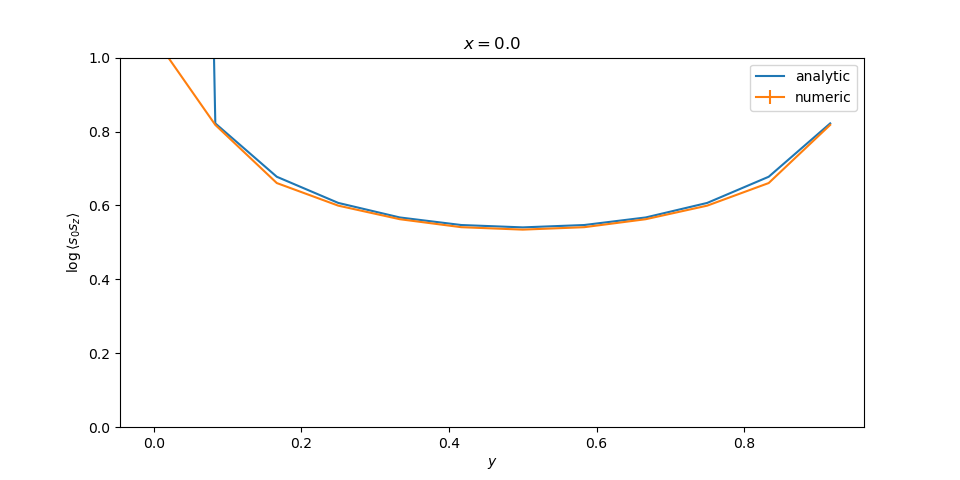

In [62]:
# plt.close()
plt.clf()

x = np.arange(0, Ly)/Ly
y = np.array( [ss_corr_analytic( t/Lx + tau*yy ) for yy in x] )

plt.plot( x, np.log(y), label="analytic" )
plt.errorbar( xt.T[1]/Ly, np.log(fac * xt.T[2]), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 1.0 )

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

plt.savefig('./ss_xslice.pdf',bbox_inches='tight')
plt.show()

## $\varepsilon$

In [63]:
eps_1pt = np.array([np.loadtxt(directory1+"eps_1pt_"+str(i)+".dat") for i in range(1, Nbintot+1)])

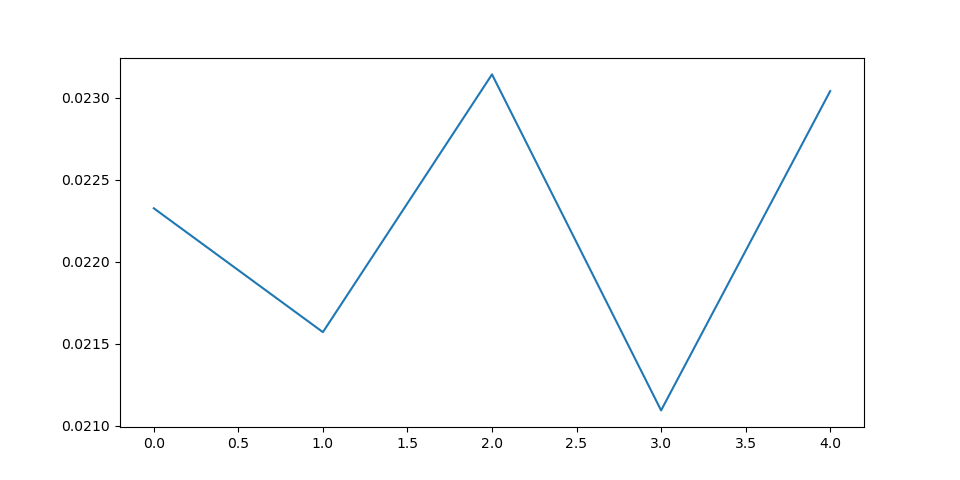

In [64]:
plt.clf()
plt.plot(eps_1pt)
plt.show()

In [65]:
np.mean(eps_1pt)

0.022235457679893288

In [66]:
# eps1 = 2.0*np.pi/r**2 * (eps_1pt - 1.0)
eps1 = 2.0*np.pi/r**2 * eps_1pt

In [67]:
jk = Jackknife( Nbin, binsize, eps1[nskip:] )

In [68]:
analytic = eps_1pt_analytic()

In [69]:
print( format_print( jk.mean(), jk.err() ) )
print( "exact", analytic )

1.289(30)
exact 1.2828455827667882


## $\varepsilon \varepsilon$

In [70]:
epseps_corr1 = np.array([np.loadtxt(directory1+"epseps_corr_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [71]:
epseps = (2.0*np.pi)**2/r**4 * np.array([ epseps_corr1[i] for i in range(Nbintot)])
jk = Jackknife( Nbin, binsize, epseps[nskip:] )

In [72]:
# plt.clf()
# plt.plot(epseps_conn[:,int(Lx/2),int(Lx/2)])
# plt.show()

In [73]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
ss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

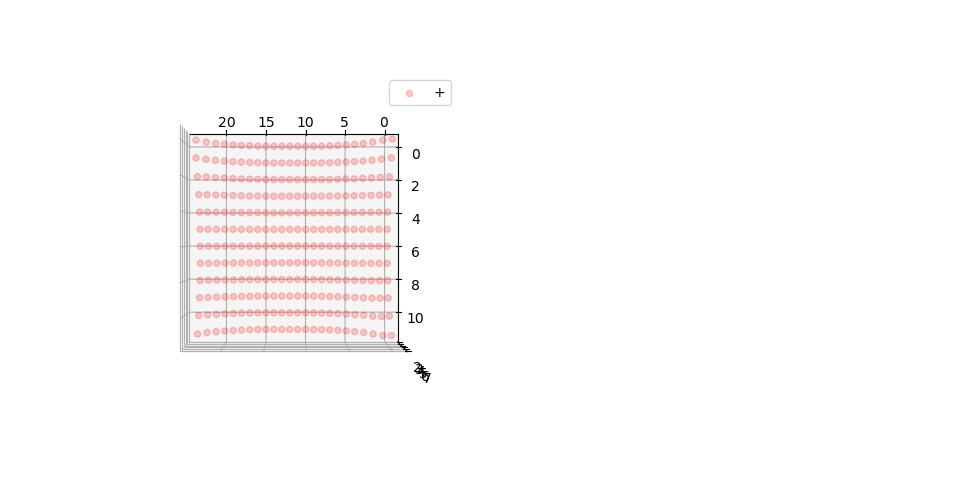

In [74]:
plt.clf()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=90)

ax.scatter(ss1.T[0], ss1.T[1], np.log( ss1.T[2]), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(ss1.T[0], ss1.T[1], np.log(-ss1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

# ax = fig.add_subplot(122, projection='3d')
# ax.view_init(elev=90., azim=90)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(etaeta_analytic.T[2])), c='r', marker='o', label="+", alpha=0.2)
# ax.scatter(etaeta_analytic.T[0], etaeta_analytic.T[1], 
#            np.log(np.real(-etaeta_analytic.T[2])), c='b', marker='o', label="-", alpha=0.2)
# ax.set_zlim( -5, 5)

# ax.legend()

# #################

# fig.tight_layout()
# # plt.savefig('../plt/re_xixi_above.pdf',bbox_inches='tight')
plt.show()

In [75]:
t = 0
yt = ss1[t*Lx:(t+1)*Lx]

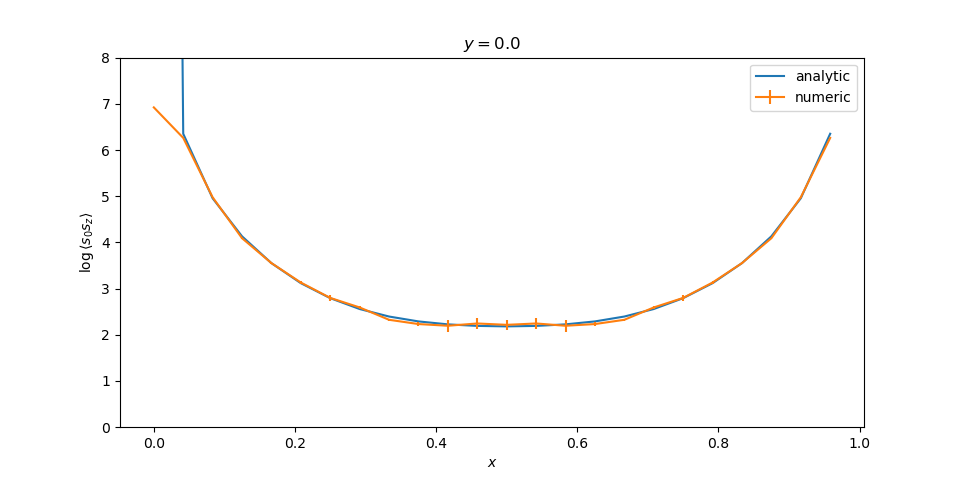

In [76]:
plt.clf()

x = np.arange(0, Lx)/Lx
y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(y), label="analytic" )

# x = np.arange(0, Lx)/Lx
# y = np.array( [epseps_corr_analytic( xx + tau*t/Ly ) for xx in x] )
# plt.plot( x, np.log(y), label="analytic" )

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2] ), np.abs(yt.T[3]/yt.T[2]), label="numeric" )

plt.legend()
plt.ylim( 0.0, 8.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")
plt.show()
# plt.savefig('./yslice.pdf',bbox_inches='tight')

In [77]:
t = 0
xt = ss1[t::Lx]

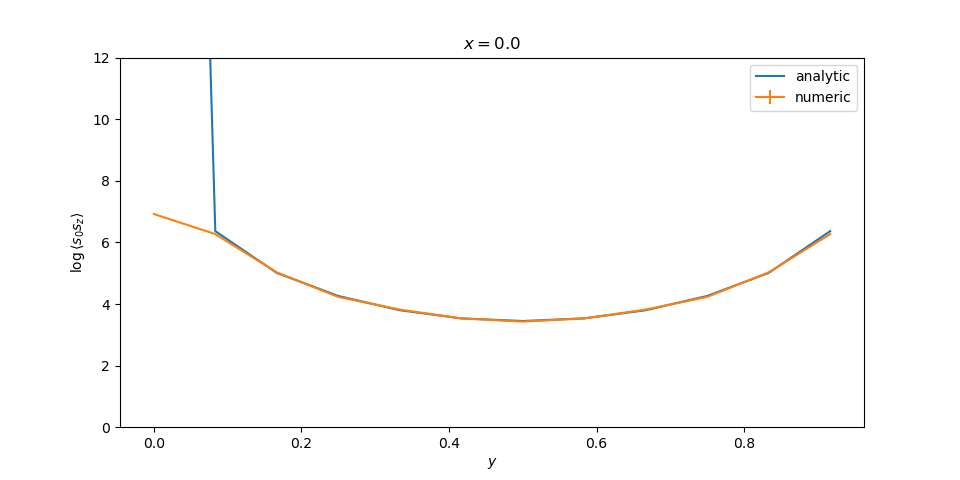

In [78]:
plt.clf()

x = np.arange(0, Ly)/Ly
y = np.array( [epseps_corr_analytic( t/Lx + tau*yy ) for yy in x] )
plt.plot( x, np.log(y), label="analytic" )

plt.errorbar( xt.T[1]/Ly, np.log( xt.T[2] ), np.abs(xt.T[3]/xt.T[2]), label="numeric" )

plt.legend()
# plt.ylim( -1.0, 0.0 )
plt.ylim( 0.0, 12.0 )

plt.title("$x="+str(t/Lx)+"$")
plt.xlabel("$y$")
plt.ylabel("$\\log\\langle s_0 s_z\\rangle $")

plt.show()
# plt.savefig('./xslice.pdf',bbox_inches='tight')

## $T$

In [79]:
Txx = np.array([np.loadtxt(directory1+"Txx_"+str(i)+".dat") for i in range(1, Nbintot+1)])
Txy = np.array([np.loadtxt(directory1+"Txy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

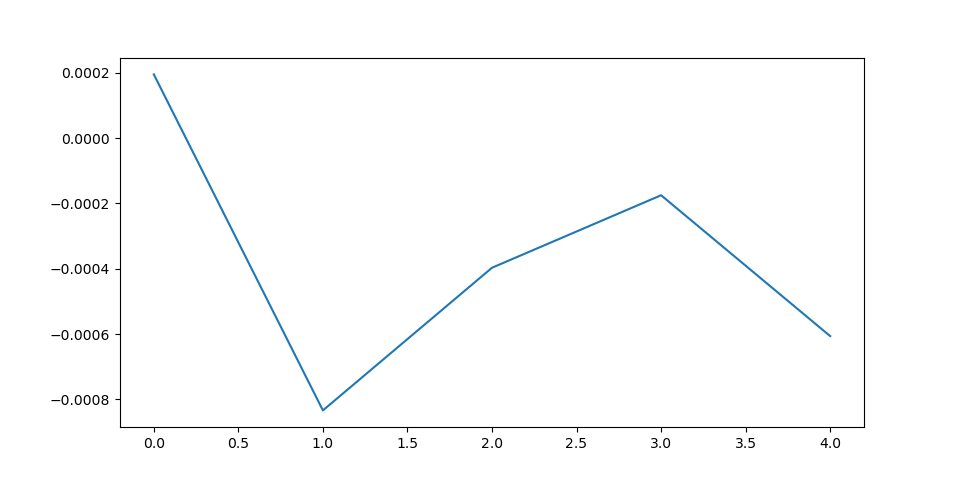

In [80]:
plt.clf()
plt.plot(Txx)
plt.show()

In [81]:
# Tnxx = -(2.0*np.pi) * 1.0/3.0 * (TB+TC-2.0*TA)/alat/r**2
# Tnxy = 1.0/np.sqrt(3.0) * (2.0*np.pi) * (TC-TB)/alat/r**2

In [82]:
Tnxx = (2.0*np.pi) * Txx/(alat)/r**2
Tnxy = (2.0*np.pi) * Txy/(alat)/r**2

In [83]:
jkxx = Jackknife( Nbin, binsize, Tnxx[nskip:] )
jkxy = Jackknife( Nbin, binsize, Tnxy[nskip:] )

In [84]:
print( format_print( 0.5*jkxx.mean(), 0.5*jkxx.err() ) )

-0.350(98)


In [85]:
print( format_print( -0.5*jkxy.mean(), 0.5*jkxy.err() ) )

-0.98(24)


In [86]:
analy = T_1pt_analytic()

In [87]:
print("Re T", format_print( 0.5*jkxx.mean(), 0.5*jkxx.err() ), analy.real )
print("Im T", format_print( -0.5*jkxy.mean(), 0.5*jkxy.err() ), analy.imag )

Re T -0.350(98) -0.6364210140582482
Im T -0.98(24) -1.1023135313533934


In [88]:
2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

80851.79925372405

In [89]:
Ly

12

## TT


In [90]:
tmp = np.array([[ [xx, yy, TT_analytic(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
TT_analy=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [91]:
TxxTxx = np.array([np.loadtxt(directory1+"TxxTxx_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [92]:
iii = Txx.shape[0]
TxxTxx = np.array([TxxTxx[ii] for ii in range(iii)])

In [93]:
jk = Jackknife( Nbin, binsize, TxxTxx[nskip:] )

In [94]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxx1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/tmp/ipykernel_9091/377274043.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_9091/377274043.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_9091/377274043.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.real(TT_analy.T[2])),
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting

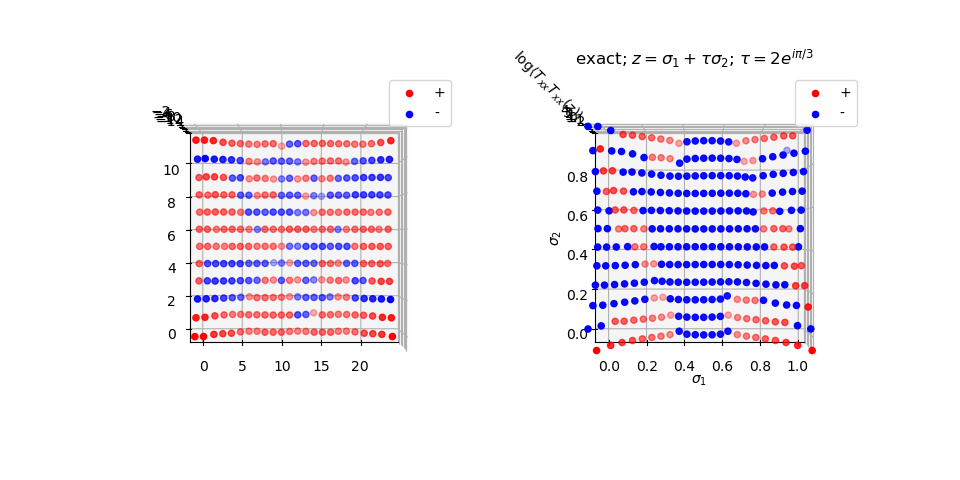

In [98]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log( TxxTxx1.T[2]), c='r', marker='o', label="+")
ax.scatter(TxxTxx1.T[0], TxxTxx1.T[1], np.log(-TxxTxx1.T[2]), c='b', marker='o', label="-")
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.real(TT_analy.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.real(TT_analy.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

plt.savefig('./TxxTxx.pdf',bbox_inches='tight')

In [99]:
t = 0 #  int(Ly/68)-1
yt = TxxTxx1[t*Lx:(t+1)*Lx]

In [105]:
y

array([-3.50619600e+63-3.46458700e+63j,  8.21819424e+04-1.21807153e+03j,
        4.97472608e+03-2.65899809e+02j,  9.20983766e+02-9.04232046e+01j,
        2.61866241e+02-3.07510755e+01j,  9.21886388e+01-5.63567379e+00j,
        3.65098124e+01+5.26624922e+00j,  1.49292007e+01+9.50358526e+00j,
        5.01738706e+00+1.07301462e+01j, -4.22420274e-01+1.08637819e+01j,
       -3.72524061e+00+1.07811234e+01j, -5.58956101e+00+1.07409724e+01j,
       -6.19932281e+00+1.07375421e+01j, -5.58956101e+00+1.07409724e+01j,
       -3.72524061e+00+1.07811234e+01j, -4.22420274e-01+1.08637819e+01j,
        5.01738706e+00+1.07301462e+01j,  1.49292007e+01+9.50358526e+00j,
        3.65098124e+01+5.26624922e+00j,  9.21886388e+01-5.63567379e+00j,
        2.61866241e+02-3.07510755e+01j,  9.20983766e+02-9.04232046e+01j,
        4.97472608e+03-2.65899809e+02j,  8.21819424e+04-1.21807153e+03j])

/tmp/ipykernel_9091/2705794930.py:2: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-np.real(2.0*y)), label="analytic(-)" )


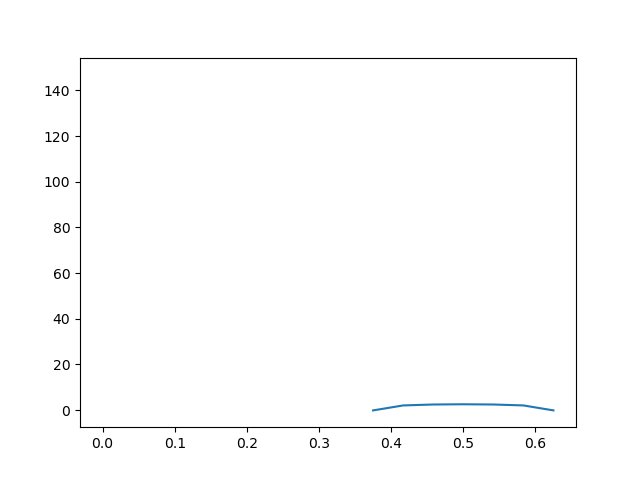

In [109]:
plt.close()
plt.plot( x, np.log(-np.real(2.0*y)), label="analytic(-)" )

/tmp/ipykernel_9091/1803561552.py:5: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )
/tmp/ipykernel_9091/1803561552.py:6: RuntimeWarning: invalid value encountered in log
  plt.plot( x, np.log(-np.real(2.0*y) ), label="analytic(-)" )
/tmp/ipykernel_9091/1803561552.py:13: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


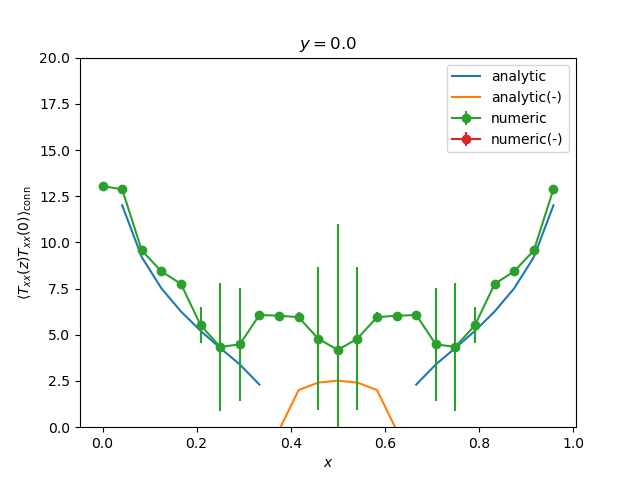

In [110]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )
plt.plot( x, np.log(-np.real(2.0*y) ), label="analytic(-)" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

plt.savefig('./yslice.pdf',bbox_inches='tight')

In [75]:
TxxTxy = np.array([np.loadtxt(directory1+"TxxTxy_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [76]:
iii = Txx.shape[0]
TxxTxy_conn = np.array([TxxTxy[ii] - Txx[ii]*Txy[ii] for ii in range(iii)])

In [77]:
jk = Jackknife( Nbin, binsize, TxxTxy_conn[nskip:] )

In [78]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
TxxTxy1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/scratch/247953.1.ood/ipykernel_985500/3160716227.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])),
/share/pkg.8/python3/3.10.12/install/lib/python3.10/site-packages/matplotlib/collections.py:192: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/scratch/247953.1.ood/ipykernel_985500/3160716227.py:20: RuntimeWarning: invalid value encountered in log
  ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T

Text(0.5, 0.92, 'exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

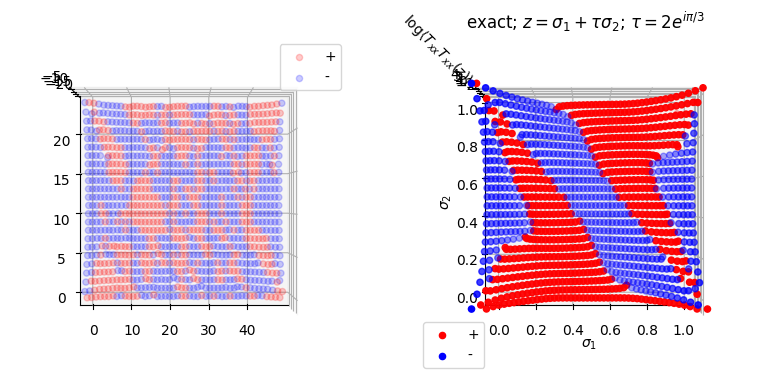

In [79]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log( TxxTxy1.T[2]), c='r', marker='o', label="+", alpha=0.2)
ax.scatter(TxxTxy1.T[0], TxxTxy1.T[1], np.log(-TxxTxy1.T[2]), c='b', marker='o', label="-", alpha=0.2)
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(-2.0*np.imag(TTconn_analytic.T[2])), 
           c='r', marker='o', label="+")
ax.scatter(TT_analy.T[0], TT_analy.T[1], np.log(2.0*np.imag(TTconn_analytic.T[2])), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

In [80]:
t = 0 #  int(Ly/68)-1
yt = TxxTxy1[t*Lx:(t+1)*Lx]

/scratch/247953.1.ood/ipykernel_985500/473554130.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/scratch/247953.1.ood/ipykernel_985500/473554130.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


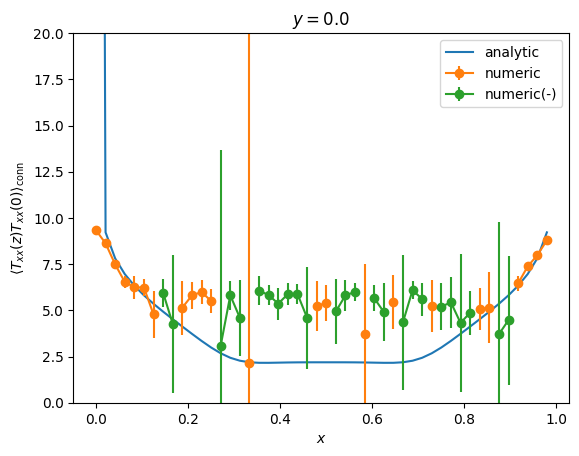

In [81]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [TT_conn_analytic( xx + tau*t/Ly ) for xx in x] )
plt.plot( x, np.log(-2.0*np.imag(y)), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## $T \varepsilon$

In [73]:
Txxeps = np.array([np.loadtxt(directory1+"Txx_eps_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [74]:
iii = Txxeps.shape[0]
Txxeps_conn = np.array([Txxeps[ii] - Txx[ii]*eps_1pt[ii] for ii in range(iii)])

In [75]:
jk = Jackknife( Nbin, binsize, Txxeps_conn[nskip:] )

In [76]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxeps1=np.array(np.split(tmp2, tmp2.shape[0]/4))

In [77]:
2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

272874.8224813185

In [78]:
tmp = np.array([[ [xx, yy, Teps_sing(xx+tau*yy) ] for xx in np.arange(0,Lx)/Lx] for yy in np.arange(0,Ly)/Ly ])
tmp2 = tmp.flatten()
Teps_sing1=np.array(np.split(tmp2, tmp2.shape[0]/3))

In [79]:
Teps_L0 = Deps_1pt_analytic()

/tmp/ipykernel_5783/1262122476.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log( Txxeps1.T[2]), c='r', marker='o', label="+")
/tmp/ipykernel_5783/1262122476.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log(-Txxeps1.T[2]), c='b', marker='o', label="-")
/tmp/ipykernel_5783/1262122476.py:18: RuntimeWarning: invalid value encountered in log
  ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(np.real(Teps_sing1.T[2] + Teps_L0)),
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/nobu/anaconda3/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexW

Text(0.5, 0.92, 'sing; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$')

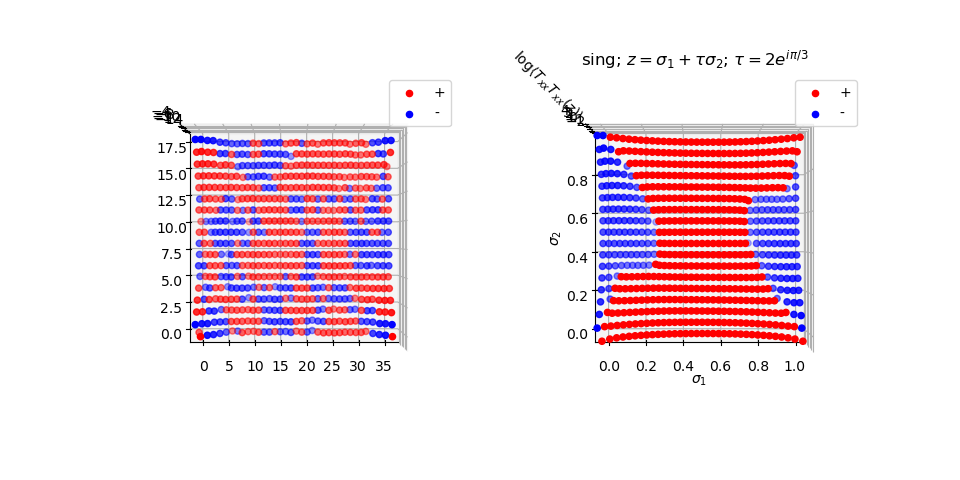

In [80]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log( Txxeps1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxeps1.T[0], Txxeps1.T[1], np.log(-Txxeps1.T[2]), c='b', marker='o', label="-")
ax.legend()

# # #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(np.real(Teps_sing1.T[2] + Teps_L0)), 
           c='r', marker='o', label="+")
ax.scatter(Teps_sing1.T[0], Teps_sing1.T[1], np.log(-np.real(Teps_sing1.T[2] + Teps_L0)), 
           c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("sing; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

# plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [81]:
t = 0 #  int(Ly/68)-1
yt = Txxeps1[t*Lx:(t+1)*Lx]

/tmp/ipykernel_5783/3066522110.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/tmp/ipykernel_5783/3066522110.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


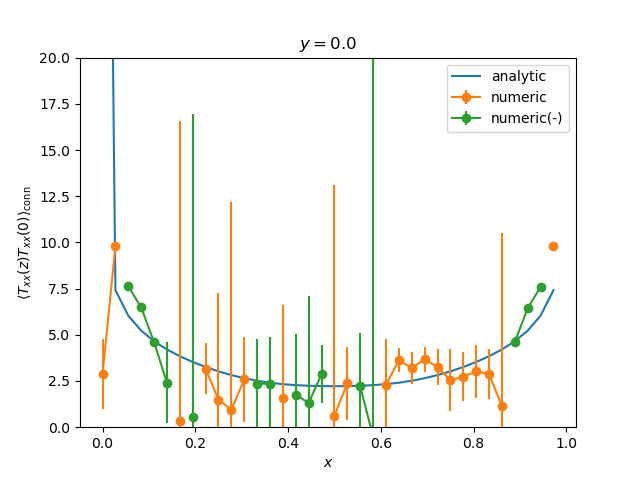

In [83]:
plt.close()

x = np.arange(0, Lx)/Lx
y = np.array( [Teps_sing( xx + tau*t/Ly ) + Teps_L0 for xx in x] )
plt.plot( x, np.log( np.real(2.0*y) ), label="analytic" )


fac = 2.0*np.pi/r**2 * (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## Tss

In [82]:
Txxss = np.array([np.loadtxt(directory1+"Txx_ss_"+str(i)+".dat") for i in range(1, Nbintot+1)])

In [83]:
iii = Txxss.shape[0]
Txxss_conn = np.array([Txxss[ii] - Txx[ii]*ss_corr1[ii] for ii in range(iii)])

In [84]:
jk = Jackknife( Nbin, binsize, Txxss_conn[nskip:] )

In [85]:
shape = jk.mean().shape
jkm = jk.mean()
jke = jk.err()
tmp = np.array([[ [xx, yy, jkm[yy,xx], jke[yy,xx] ] for xx in range(shape[1])] for yy in range(shape[0])])

tmp2 = tmp.flatten()
Txxss1=np.array(np.split(tmp2, tmp2.shape[0]/4))

/scratch/247953.1.ood/ipykernel_985500/2061575007.py:9: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log( Txxss1.T[2]), c='r', marker='o', label="+")
/scratch/247953.1.ood/ipykernel_985500/2061575007.py:10: RuntimeWarning: invalid value encountered in log
  ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-")
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


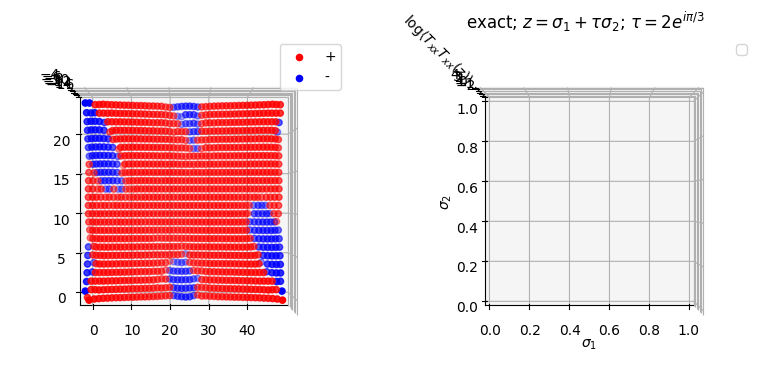

In [86]:
plt.close()
fig = plt.figure(figsize=plt.figaspect(0.5))

#################

ax = fig.add_subplot(121, projection='3d')
ax.view_init(elev=90., azim=-90)

ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log( Txxss1.T[2]), c='r', marker='o', label="+")
ax.scatter(Txxss1.T[0], Txxss1.T[1], np.log(-Txxss1.T[2]), c='b', marker='o', label="-")
ax.legend()

# #################

ax = fig.add_subplot(122, projection='3d')
ax.view_init(elev=90., azim=-90)

# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(2.0*np.real(TTconn_analytic.T[2])), 
#            c='r', marker='o', label="+")
# ax.scatter(TTconn_analytic.T[0], TTconn_analytic.T[1], np.log(-2.0*np.real(TTconn_analytic.T[2])), 
#            c='b', marker='o', label="-")

ax.set_zlim(-2, 4)
ax.legend()
ax.set_xlabel("$\\sigma_1$")
ax.set_ylabel("$\\sigma_2$")
ax.set_zlabel("${\\rm log} \\langle T_{xx}T_{xx}(z) \\rangle$")
ax.set_title("exact; $z=\\sigma_1+\\tau \\sigma_2$; $\\tau = 2e^{i\\pi/3}$")

# #################

plt.savefig('./Txxss.pdf',bbox_inches='tight')

In [89]:
t = 3 #  int(Ly/68)-1
yt = Txxss1[t*Lx:(t+1)*Lx]

/scratch/247953.1.ood/ipykernel_985500/1592740195.py:11: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
/scratch/247953.1.ood/ipykernel_985500/1592740195.py:12: RuntimeWarning: invalid value encountered in log
  plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )


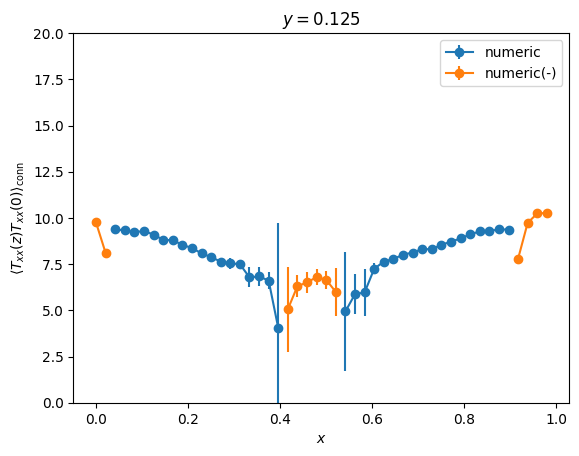

In [90]:
plt.close()

# x = np.arange(0, Lx)/Lx
# y = np.array( [TT_conn_analytic( xx + tau*t/Ly ) for xx in x] )
# plt.plot( x, np.log(2.0*y), label="analytic" )


fac = (2.0*np.pi)/(alat)/r**2

# plt.errorbar( yt.T[0]/Lx, yt.T[2], np.abs(yt.T[3]/yt.T[2]), label="numeric" )
plt.errorbar( yt.T[0]/Lx, np.log( yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric", marker='o' )
plt.errorbar( yt.T[0]/Lx, np.log( -yt.T[2]*fac**2 ), np.abs(yt.T[3]/yt.T[2]), label="numeric(-)", marker='o' )
# plt.errorbar( yt.T[0]/Lx, yt.T[2], yt.T[3], label="numeric", marker='o' )

plt.legend()

plt.ylim( 0.0, 20.0 )

plt.title("$y="+str(t/Ly)+"$")
plt.xlabel("$x$")
plt.ylabel("$\\langle T_{xx}(z) T_{xx}(0)\\rangle_{\\rm conn}$")

# plt.xscale("log")

# xx=(yt.T[0]/Lx)[3:]
# yy=1.0/xx**4
# plt.plot( xx, np.log(1.0e-5*yy) )

plt.show()

# plt.savefig('./yslice.pdf',bbox_inches='tight')

## CHECK

In [50]:
# Nbintot=120
# nskip = 20
# Nbin = Nbintot-nskip

KA = np.array([np.loadtxt(directory1+"KA_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KB = np.array([np.loadtxt(directory1+"KB_"+str(i)+".dat") for i in range(1, Nbintot+1)])
KC = np.array([np.loadtxt(directory1+"KC_"+str(i)+".dat") for i in range(1, Nbintot+1)])

FileNotFoundError: ./data_Lx9Ly12nu1/KA_1.dat not found.

In [57]:
t0 = KA - tanhbeta*B
jk = Jackknife( Nbin, binsize, t0[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.292603(21)'

In [58]:
t1 = KB - tanhbeta*B
jk = Jackknife( Nbin, binsize, t1[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291102(21)'

In [59]:
t2 = KC - tanhbeta*B
jk = Jackknife( Nbin, binsize, t2[nskip:] )
format_print( jk.mean(), jk.err()  )

'0.291001(20)'

In [60]:
tmp = t1+t2-2.0*t0
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.003103(30)'

In [61]:
tmp = t2-t1
jk = Jackknife( Nbin, binsize, tmp[nskip:] )
format_print( jk.mean(), jk.err() )

'-0.000101(16)'

In [62]:
Txx_1pt = (2.0*np.pi) * 1.0/3.0 * (2.0*t0-t1-t2)/alat/r**2
Txy_1pt = (2.0*np.pi) * 1.0/np.sqrt(3.0) * (t2-t1)/alat/r**2
jk_xx = Jackknife( Nbin, binsize, Txx_1pt[nskip:] )
jk_xy = Jackknife( Nbin, binsize, Txy_1pt[nskip:] )
print(format_print( jk_xx.mean(), jk_xx.err()  ) )
print(format_print( jk_xy.mean(), jk_xy.err()  ) )

0.2026(20)
-0.0114(18)


In [63]:
analy = T_1pt_analytic()

In [68]:
print("Re T", format_print( 0.5*jk_xx.mean(), 0.5*jk_xx.err() ), analy.real )
print("Im T", format_print( -0.5*jk_xy.mean(), 0.5*jk_xy.err() ), analy.imag )

Re T 0.10132(99) 0.1075772266133182
Im T 0.00569(91) 0.006923613578085176
